# Dogs vs Cats Redux

## Download the Data
Download the dataset from [dogs-vs-cats-redux-kernels-edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data), unzip it and store it inside the **data** folder, such that your directory structure is like below.
```
dogs-vs-cats/
    dogs-vs-cats.ipynb
    vgg16.py
    vgg16bn.py
    utils.py
    data/
        train/
            cat.437.jpg
            dog.9924.jpg
            cat.1029.jpg
            dog.4374.jpg
        test/
            231.jpg
            325.jpg
            1235.jpg
            9923.jpg
```

In [1]:
import os, sys

CURRENT_DIR = os.getcwd()
HOME_DIR = CURRENT_DIR
DATA_DIR = HOME_DIR + "/data"

In [2]:
%matplotlib inline

## Action Plan
1. Create Sample and Validation datasets
2. Copy Cats and Dogs to their respective directories
3. Finetune and train the model
4. Generate the predictions
5. Validate the prediction
6. Submit to Kaggle

## Create Sample and Validation Datasets

In [6]:
# make sure that you are in the dogs-vs-cats directory
%pwd

u'/home/ubuntu/fast.ai/nbs/dogs-vs-cats'

In [7]:
# change to data directory
%cd $DATA_DIR

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data


In [8]:
# create directories

%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘results’: File exists


In [9]:
%cd $DATA_DIR/train

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data/train


In [11]:
# extract validation set from the train dataset
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    os.rename(shuf[i], DATA_DIR + "/valid/" + shuf[i])

In [12]:
from shutil import copyfile

In [13]:
# copy some files from train dataset to be used as sample dataset for quick experimentation
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200):
    copyfile(shuf[i], DATA_DIR + "/sample/train/" + shuf[i])

In [14]:
%cd $DATA_DIR/valid

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data/valid


In [15]:
# copy some files from train dataset to be used as sample dataset for quick experimentation
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50):
    copyfile(shuf[i], DATA_DIR + "/sample/valid/" + shuf[i])

## Divide Cats and Dogs into separate directories

In [ ]:
%cd $DATA_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [20]:
# Create single 'unknown' class for test set
%cd $DATA_DIR/test
%mv *.jpg unknown/

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data/test


## Utitilty Functions

In [13]:
# Utility functions
import bcolz
import itertools
import numpy as np
from keras.preprocessing import image
from matplotlib import pyplot as plt

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def get_batches(path, gen=image.ImageDataGenerator(preprocessing_function=preprocess), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Finetuning and Training

In [30]:
%cd $DATA_DIR

#Set path to sample/ path if desired
path = DATA_DIR + '/' #'/sample/'
test_path = DATA_DIR + '/test/' #We use all the test data
results_path=DATA_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data


In [46]:
batch_size = 64
no_of_epochs = 3

batches = get_batches(train_path, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## InceptionV3 Model

In [22]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=no_of_epochs,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/5
200/200 [==============================] - 4s - loss: 0.6054 - acc: 0.7350 - val_loss: 2.1478 - val_acc: 0.6400
Epoch 2/5
200/200 [==============================] - 3s - loss: 0.2862 - acc: 0.9400 - val_loss: 1.9176 - val_acc: 0.7200
Epoch 3/5
200/200 [==============================] - 2s - loss: 0.1488 - acc: 0.9350 - val_loss: 0.9716 - val_acc: 0.8600
Epoch 4/5
200/200 [==============================] - 3s - loss: 0.0634 - acc: 0.9750 - val_loss: 1.0854 - val_acc: 0.8400
Epoch 5/5
200/200 [==============================] - 3s - loss: 0.0198 - acc: 0.9900 - val_loss: 1.3671 - val_acc: 0.8000


## VGG-16 Model

In [36]:
%cd $HOME_DIR

import vgg16; reload(vgg16)
from vgg16 import Vgg16

%cd $DATA_DIR

vgg = Vgg16()

/home/ubuntu/fast.ai/nbs/dogs-vs-cats
/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data


In [47]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [48]:
vgg.model.optimizer.lr = 0.01

In [ ]:
# for each epoch, we test our model against the validateion set
latest_weight_filename = None
for epoch in range(no_of_epochs):
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weight_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path + latest_weight_filename)

Epoch 1/1
23000/23000 [==============================] - 614s - loss: 0.3713 - acc: 0.9689 - val_loss: 0.2690 - val_acc: 0.9775
Epoch 1/1
23000/23000 [==============================] - 615s - loss: 0.3297 - acc: 0.9762 - val_loss: 0.2489 - val_acc: 0.9830
Epoch 1/1
 4032/23000 [====>.........................] - ETA: 469s - loss: 0.2796 - acc: 0.9789

## Generate Predictions

In [54]:
vgg.model.load_weights(results_path + latest_weight_filename)
batches, preds = vgg.test(test_path, batch_size=batch_size*2)

Found 12500 images belonging to 1 classes.


In [55]:
preds[:5]

array([[  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   4.20389539e-45],
       [  1.90565691e-34,   1.00000000e+00]], dtype=float32)

In [56]:
filenames = batches.filenames
filenames[:5]

['unknown/2790.jpg',
 'unknown/5359.jpg',
 'unknown/5604.jpg',
 'unknown/4440.jpg',
 'unknown/7475.jpg']

In [57]:
save_array(results_path + "test_preds.dat", preds)
save_array(results_path + "filenames.dat", filenames)

## Validate Predictions

In [58]:
# calculate prediction on validation set so we can find correct and incorrect labels
vgg.model.load_weights(results_path + latest_weight_filename)
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [ ]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [59]:
#Number of images to view for each visualization task
n_view = 4

Found 1957 correct labels


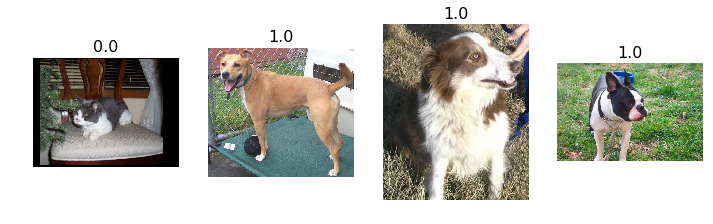

In [60]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, our_labels[idx])

Found 43 incorrect labels


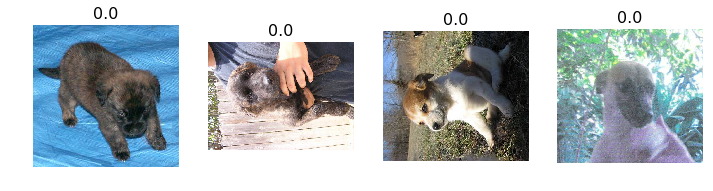

In [61]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, our_labels[idx])

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[1002   18]
 [  25  955]]


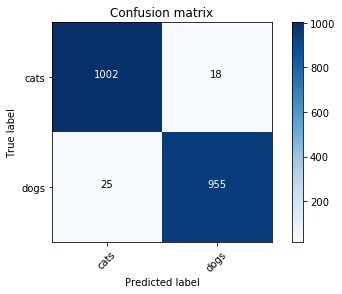

In [68]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate the submission.

In [69]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [70]:
#Grab the dog prediction column
isdog = preds[:,1]

In [71]:
isdog = isdog.clip(min=0.05, max=0.95)

In [72]:
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [73]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  2.79000000e+03,   5.00000007e-02],
       [  5.35900000e+03,   5.00000007e-02],
       [  5.60400000e+03,   9.49999988e-01],
       [  4.44000000e+03,   5.00000007e-02],
       [  7.47500000e+03,   9.49999988e-01]])

In [74]:
%cd $DATA_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data


In [75]:
from IPython.display import FileLink
%cd $HOME_DIR
FileLink('data/'+submission_file_name)

/home/ubuntu/fast.ai/nbs/dogs-vs-cats


/home/ubuntu/fast.ai/nbs/dogs-vs-cats/data/submission1.csv